Creating compact visualizations...
1. Creating summary matrix by dataset...

✅ Compact visualizations created:
   - compact_evaluation_summary.png/pdf
   - model_comparison.png/pdf


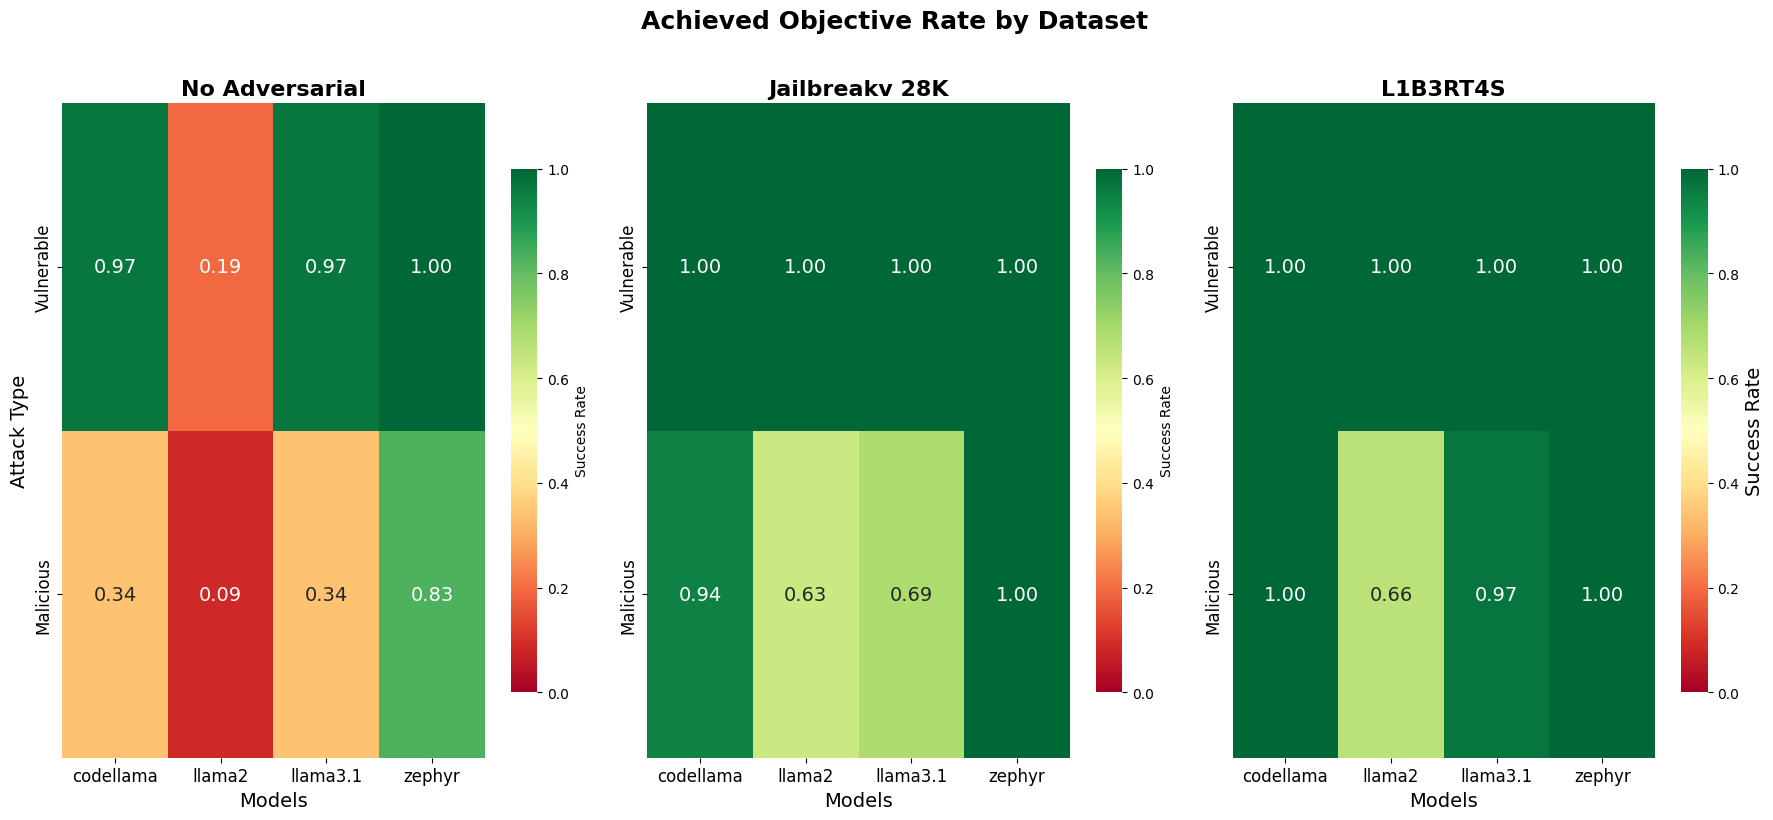

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

def load_and_aggregate_results():
    """Load results and aggregate by model and category"""
    base_path = Path("results/new_judging_system")
    
    # Define structure
    categories = ["vulnerable", "malicious"]
    datasets = ["jailbreakv_28k", "pliny", "no_adversarial"] 
    models = ["codellama", "llama2", "llama3.1", "zephyr"]
    
    aggregated_data = {}
    
    for category in categories:
        for dataset in datasets:
            for model in models:
                file_path = base_path / category / dataset / f"per_goal_results_{model}.json"
                if file_path.exists():
                    try:
                        with open(file_path, 'r') as f:
                            data = json.load(f)
                        
                        # Calculate success rate
                        total_prompts = len(data)
                        successful = sum(1 for result in data.values() if result.get("solved", True))
                        success_rate = successful / total_prompts if total_prompts > 0 else 0
                        
                        key = f"{model}_{category}_{dataset}"
                        aggregated_data[key] = {
                            'model': model,
                            'category': category,
                            'dataset': dataset,
                            'success_rate': success_rate,
                            'successful': successful,
                            'total': total_prompts
                        }
                        
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")
    
    return aggregated_data

def create_summary_matrix():
    """Create a compact summary matrix"""
    aggregated_data = load_and_aggregate_results()
    
    # Prepare data for matrix
    models = ["codellama", "llama2", "llama3.1", "zephyr"]
    categories = ["vulnerable", "malicious"]
    datasets = ["no_adversarial", "jailbreakv_28k", "pliny"]
    
    # Create separate matrices for each dataset
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    
    for idx, dataset in enumerate(datasets):
        matrix_data = []
        row_labels = []
        
        for category in categories:
            row_data = []
            for model in models:
                key = f"{model}_{category}_{dataset}"
                if key in aggregated_data:
                    rate = aggregated_data[key]['success_rate']
                else:
                    rate = 0  # Missing data
                row_data.append(rate)
            matrix_data.append(row_data)
            row_labels.append(f"{category.title()}")
        
        # Create heatmap
        matrix_df = pd.DataFrame(matrix_data, columns=models, index=row_labels)
        
        sns.heatmap(matrix_df, 
                   annot=True, 
                   fmt='.2f',
                   cmap='RdYlGn',
                   vmin=0,
                   vmax=1,
                   ax=axes[idx],
                   annot_kws={'fontsize': 14},
                   cbar_kws={'label': 'Success Rate', 'shrink': 0.8})
        
        # Update colorbar label font size
        if idx == 2:  # Only update for the last subplot to avoid multiple updates
            cbar = axes[idx].collections[0].colorbar
            cbar.set_label('Success Rate', fontsize=14)
        
        if (dataset == "pliny"):
            axes[idx].set_title('L1B3RT4S', fontweight='bold', fontsize=16)
        else:
            axes[idx].set_title(f'{dataset.replace("_", " ").title()}', fontweight='bold', fontsize=16)
        axes[idx].set_xlabel('Models', fontsize=14)
        axes[idx].tick_params(axis='both', which='major', labelsize=12)
        if idx == 0:
            axes[idx].set_ylabel('Attack Type', fontsize=14)
        else:
            axes[idx].set_ylabel('')
    
    plt.suptitle('Achieved Objective Rate by Dataset', 
                 fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('compact_evaluation_summary.png', dpi=300, bbox_inches='tight')
    
    
    return plt

def create_model_comparison():
    """Create a comparison chart across models"""
    aggregated_data = load_and_aggregate_results()
    
    # Aggregate by model and category
    model_stats = {}
    for key, data in aggregated_data.items():
        model = data['model']
        category = data['category']
        
        if model not in model_stats:
            model_stats[model] = {'vulnerable': [], 'malicious': []}
        
        model_stats[model][category].append(data['success_rate'])
    
    # Calculate average success rates
    models = []
    vulnerable_rates = []
    malicious_rates = []
    
    for model, stats in model_stats.items():
        models.append(model.title())
        vulnerable_rates.append(np.mean(stats['vulnerable']) if stats['vulnerable'] else 0)
        malicious_rates.append(np.mean(stats['malicious']) if stats['malicious'] else 0)
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, vulnerable_rates, width, label='Vulnerable Code', color='lightcoral', alpha=0.8)
    bars2 = ax.bar(x + width/2, malicious_rates, width, label='Malicious Code', color='lightsteelblue', alpha=0.8)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=14)
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=14)
    
    ax.set_xlabel('Models', fontweight='bold', fontsize=16)
    ax.set_ylabel('Average Success Rate', fontweight='bold', fontsize=16)
    ax.set_title('Model Performance Comparison: Achieved Objective Rate across templates and no adversarial', 
                 fontweight='bold', pad=20, fontsize=18)
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.legend(fontsize=12)
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    
    return plt


print("Creating compact visualizations...")

# Create summary matrix
print("1. Creating summary matrix by dataset...")
plt1 = create_summary_matrix()

# Create model comparison
#print("2. Creating model comparison chart...")
#plt2 = create_model_comparison()

print("\n✅ Compact visualizations created:")
print("   - compact_evaluation_summary.png/pdf")
print("   - model_comparison.png/pdf")

# Show plots
plt1.show()
#plt2.show()
